In [1]:
# Installing the dependencies in our virtual environment.
# Please note that we will be using Tensorflow 2.4.1 which requires python 3.6 - 3.8. So, here we use python 3.7.3
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
import uuid
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
tf.test.is_built_with_cuda()

True

In [7]:
# # Setup Paths
# POS_PATH = os.path.join('data', 'positive')
# NEG_PATH = os.path.join('data', 'negative')
# ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Setup Paths
POS_PATH = 'data/positive'
NEG_PATH = 'data/negative'
ANC_PATH = 'data/anchor'

In [9]:
# Now, let's make the above directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [10]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
# !tar -xf lfw.tgz

In [11]:
# Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [12]:
# cap = cv2.VideoCapture(0)                # This cell was just for looking at the output
# while cap.isOpened():
#     ret, frame = cap.read()
#     cv2.imshow('Image Collection', frame)
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()
# plt.imshow(frame[115:115+250, 195:195+250, :])
# print(frame.shape)
# print(frame[115:115+250, 195:195+250, :].shape)

In [13]:
# # Establish a connection to the webcam
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()
    
#     # Cut down the frame to 250x250px
#     frame = frame[115:115+250, 195:195+250, :]
    
#     # Collect Anchors
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         # Create the unique file path
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # Writeout anchor image
#         cv2.imwrite(imgname, frame)
        
#     # Collect Positives
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         # Create the unique file path
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # Writeout positive image
#         cv2.imwrite(imgname, frame)
        
#     cv2.imshow('Image Collection', frame)
        
#     # Breaking out
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break
    
# # Release the webcam
# cap.release()
# # Close the image show frame
# cv2.destroyAllWindows()

In [14]:
# # Data augmentation.
# # Let's make our data 10 times!!!

# def data_aug(img):
#     data = []
#     for i in range(9):
#         img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
#         img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
#         # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
#         img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
#         img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
#         img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
#         data.append(img)
    
#     return data

In [15]:
# img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
# img = cv2.imread(img_path)                            # This cell was just to see the output and no need to run
# augmented_images = data_aug(img)

# for image in augmented_images:
#     cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [16]:
# # Populating the folders with the Augmented data
# for file_name in os.listdir(os.path.join(POS_PATH)):
#     img_path = os.path.join(POS_PATH, file_name)
#     img = cv2.imread(img_path)
#     augmented_images = data_aug(img) 
    
#     for image in augmented_images:
#         cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [17]:
# # Populating the folders with the Augmented data
# for file_name in os.listdir(os.path.join(ANC_PATH)):
#     img_path = os.path.join(ANC_PATH, file_name)
#     img = cv2.imread(img_path)
#     augmented_images = data_aug(img) 
    
#     for image in augmented_images:
#         cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [7]:
# Get image directories
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(3200) #7800
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(3200)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(3200)

In [8]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Scale image to be between 0 and 1
    img = img / 255.0
    
    # Return image
    return img

In [9]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [10]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [11]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 10000)

In [12]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [13]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [14]:
# Build Embedding Layer

def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    # First Block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    # Second Block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
    # Third Block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [15]:
embedding = make_embedding()

In [16]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [17]:
# Siamese L1 Distance class

class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [18]:
siamese_layer = L1Dist()

In [19]:
# Make Siamese Model

def make_siamese_model():
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [20]:
siamese_model = make_siamese_model()

In [21]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

In [22]:
# Training

# Setup Loss and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [23]:
opt = tf.keras.optimizers.Adam(1e-4)

In [24]:
# Establish Checkpoints

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [25]:
# Build Train Step Function

@tf.function
def train_step(batch):
    
    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        x = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(x, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [26]:
# Evaluate model
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [27]:
# Build Training Loop

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
            
        print('Loss = ', loss.numpy())
        print('Precision = ', p.result().numpy())
        print('Recall = ', r.result().numpy())
            
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

In [39]:
# # Train the model
# train(train_data, 5)


 Epoch 1/5
280/280 [==============================] - 223s 292ms/step
Loss =  0.22235832
Precision =  0.9875622
Recall =  0.8873491

 Epoch 2/5
280/280 [==============================] - 80s 285ms/step
Loss =  0.041965082
Precision =  0.9976581
Recall =  0.95816463

 Epoch 3/5
280/280 [==============================] - 79s 281ms/step
Loss =  0.00686481
Precision =  0.99274045
Recall =  0.97287685

 Epoch 4/5
280/280 [==============================] - 78s 279ms/step
Loss =  0.017219724
Precision =  0.99135184
Recall =  0.982852

 Epoch 5/5
280/280 [==============================] - 78s 278ms/step
Loss =  0.019251391
Precision =  0.9959331
Recall =  0.9941362


<PrefetchDataset shapes: ((None, 100, 100, None), (None, 100, 100, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>


In [ ]:
a = 0
b = 0
for test_input in test_data

In [40]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [41]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])

In [42]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1]

In [43]:
print(y_true)

[1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1.]


In [44]:
# Calculate metrics
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [45]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [46]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

0.93849206 1.0


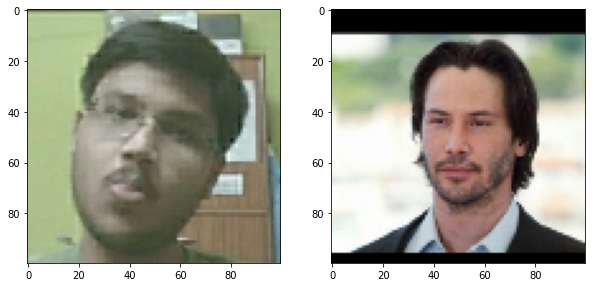

In [47]:
# Visualize Results
# Set plot size
plt.figure(figsize=(10, 8))

# Set first subplot
plt.subplot(1, 2, 1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1, 2, 2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [48]:
# # Save Model

# # Save weights
# siamese_model.save('siamesemodelv2.h5')

In [49]:
# Reload model
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5',
                                   custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [50]:
# Make predictions with reloaded model
y_hat = siamese_model.predict([test_input, test_val])

In [51]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1]

In [52]:
print(y_true)

[0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1.]


In [53]:
# Calculate metrics
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [54]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [55]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

0.93368423 1.0


In [56]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [57]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir('application_data/verification_images'):
        input_img = preprocess('application_data/input_image/input_image.jpg')
        validation_img = preprocess(os.path.join('application_data/verification_images', image))
        
        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
        results.append(result)
        
    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold) # Number of positive predictions
    
    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir('application_data/verification_images')) # Predicted Positive / no. of verification_images
    verified = verification > verification_threshold
    
    return results, verified

In [58]:
# def verify(model, detection_threshold, verification_threshold):
#     # Build results array
#     results = []
#     for image in os.listdir(os.path.join('application_data', 'verification_images')):
#         input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
#         validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
#         # Make Predictions
#         result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
#         results.append(result)
        
#     # Detection Threshold: Metric above which a prediction is considered positive
#     detection = np.sum(np.array(results) > detection_threshold) # Number of positive predictions
    
#     # Verification Threshold: Proportion of positive predictions / total positive samples
#     verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) # Predicted Positive / no. of verification_images
#     verified = verification > verification_threshold
    
#     return results, verified

In [59]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[115:115+250, 195:195+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
        cv2.imwrite('application_data/input_image/input_image.jpg', frame)
        # Run verification
#         results, verified = verify(model, 0.8, 0.6)
        results, verified = verify(siamese_model, 0.5, 0.6)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

False
False
False
False
False
False


In [60]:
results, verified = verify(siamese_model, 0.5, 0.6)
np.sum(np.squeeze(results) > 0.9)

0